In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
# model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True, )

def local_fcn_resnet( backbone, num_classes, aux, aux2):
    return_layers = {"layer4": "out"}
    if aux:
        return_layers["layer3"] = "aux"
    if aux2:
        return_layers["layer2"] = "aux2"
    backbone = torchvision.models.segmentation.segmentation.IntermediateLayerGetter(backbone, return_layers=return_layers)

    aux_classifier = torchvision.models.segmentation.segmentation.FCNHead(1024, num_classes) if aux else None
    classifier = torchvision.models.segmentation.segmentation.FCNHead(2048, num_classes)
    return torchvision.models.segmentation.segmentation.FCN(backbone, classifier, aux_classifier)

torchvision.models.segmentation.segmentation._fcn_resnet = local_fcn_resnet
model = torchvision.models.segmentation.segmentation.fcn_resnet50(pretrained=False, num_classes=2, aux_loss = True, pretrained_backbone=True)

from torch.utils.data import DataLoader
from generate_training_validation_data import CustomImageDataset
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import cv2 as cv

from collections import namedtuple
from typing import Any
import torch
import torch.optim as optim
import torch.nn as nn
import copy

train_data_dir = 'D:/MemeMachine_ProjectData/dataset/training'
validation_data_dir = 'D:/MemeMachine_ProjectData/dataset/validation'
img_width, img_height, n_channels = 250, 250, 3 #TODO change dimensions to be wider, to better support text

epochs = 1 #50 TODO
batch_size = 1
classes = ['nothing', 'text']
# classes = ['text']


#change the number of classes in the final step of the classifier
# print(model.classifier[4])
model.classifier[4] = torch.nn.Conv2d(512, len(classes), kernel_size=(1,1), stride = (1,1))
torch.nn.init.xavier_uniform(model.classifier[4].weight)

# print(model.aux_classifier[4])
model.aux_classifier[4] = torch.nn.Conv2d(256, len(classes), kernel_size=(1,1), stride = (1,1))
torch.nn.init.xavier_uniform(model.aux_classifier[4].weight)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\maxan/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 19.4MB/s]
c:\Users\maxan\Documents\Programming\MemeMachine\MemeMachine\TextPixelMasking\GPUtextPixelMasking\lib\site-packages\ipykernel_launcher.py:49: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
c:\Users\maxan\Documents\Programming\MemeMachine\MemeMachine\TextPixelMasking\GPUtextPixelMasking\lib\site-packages\ipykernel_launcher.py:53: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Parameter containing:
tensor([[[[ 0.0181]],

         [[ 0.0964]],

         [[ 0.0216]],

         [[-0.0672]],

         [[-0.0714]],

         [[-0.0233]],

         [[ 0.0857]],

         [[ 0.0158]],

         [[-0.1058]],

         [[-0.0642]],

         [[ 0.1452]],

         [[-0.0408]],

         [[ 0.0443]],

         [[-0.0162]],

         [[ 0.1414]],

         [[-0.0201]],

         [[ 0.0062]],

         [[ 0.1128]],

         [[-0.0430]],

         [[ 0.1042]],

         [[ 0.0944]],

         [[ 0.0491]],

         [[ 0.0463]],

         [[ 0.1076]],

         [[ 0.0518]],

         [[-0.1227]],

         [[-0.1307]],

         [[ 0.1225]],

         [[ 0.0194]],

         [[ 0.0506]],

         [[-0.1264]],

         [[-0.0586]],

         [[-0.1272]],

         [[-0.1171]],

         [[-0.1036]],

         [[-0.0667]],

         [[ 0.1178]],

         [[ 0.1066]],

         [[-0.0974]],

         [[-0.1001]],

         [[ 0.1268]],

         [[ 0.0319]],

         [[ 

In [2]:
experiment_name = "ShallowerHead_Test28"

In [3]:
torch.backends.cudnn.benchmark = True


"""             CUDA Troubleshooting            """

# %env CUDA_LAUNCH_BLOCKING=1

# import torch
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.deterministic = False
# torch.backends.cudnn.allow_tf32 = True
# data = torch.randn([1, 512, 16, 16], dtype=torch.float, device='cuda', requires_grad=True)
# net = torch.nn.Conv2d(512, 1, kernel_size=[1, 1], padding=[0, 0], stride=[1, 1], dilation=[1, 1], groups=1)
# net = net.cuda().float()
# out = net(data)
# out.backward(torch.randn_like(out))
# torch.cuda.synchronize()



'             CUDA Troubleshooting            '

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least `224` pixels.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes.
`output['out']` contains the semantic masks, and `output['aux']` contains the auxillary loss values per-pixel. In inference mode, `output['aux']` is not useful.
So, `output['out']` is of shape `(N, 21, H, W)`. More documentation can be found [here](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

Feature batch shape: torch.Size([1, 3, 250, 250])
Labels batch shape: torch.Size([1, 62500])


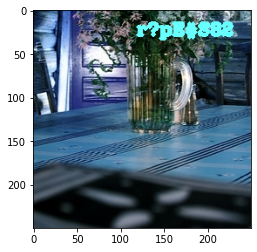

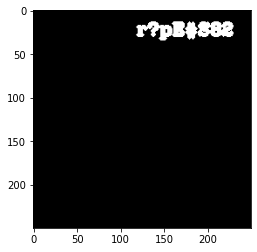

In [4]:
import optuna

# Select an image from the dataset

#TODO change image_with_text_functions.generate_text_on_image_and_pixel_mask_from_path to place the text properly
train_dataset = CustomImageDataset(train_data_dir, img_width, img_height)
test_dataset = CustomImageDataset(validation_data_dir, img_width, img_height)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
input_image = train_features[0].squeeze()
input_image = np.moveaxis(input_image.numpy(), 0, -1)
label = train_labels[0].reshape((img_width, img_height))

plt.imshow(input_image, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()

The output here is of shape `(21, H, W)`, and at each location, there are unnormalized probabilities corresponding to the prediction of each class.
To get the maximum prediction of each class, and then use it for a downstream task, you can do `output_predictions = output.argmax(0)`.

Here's a small snippet that plots the predictions, with each color being assigned to each class (see the visualized image on the left).

### Model Description

FCN-ResNet is constructed by a Fully-Convolutional Network model, using a ResNet-50 or a ResNet-101 backbone.
The pre-trained models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

| Model structure |   Mean IOU  | Global Pixelwise Accuracy |
| --------------- | ----------- | --------------------------|
|  fcn_resnet50   |   60.5      |   91.4                    |
|  fcn_resnet101  |   63.7      |   91.9                    |

### Resources

 - [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1605.06211)

In [5]:

# pylint: disable = abstract-method
class ModelWrapper(torch.nn.Module):
    """
    Wrapper class for model with dict/list rvalues.
    """

    def __init__(self, model: torch.nn.Module) -> None:
        """
        Init call.
        """
        super().__init__()
        self.model = model

    def forward(self, input_x: torch.Tensor) -> Any:
        """
        Wrap forward call.
        """
        data = self.model(input_x)

        if isinstance(data, dict):
            data_named_tuple = namedtuple("ModelEndpoints", sorted(data.keys()))  # type: ignore
            data = data_named_tuple(**data)  # type: ignore

        elif isinstance(data, list):
            data = tuple(data)

        return data

In [6]:
from torch.utils.tensorboard import SummaryWriter
# # default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/FCN_resnet101_GPU_text_pixel_masking/'+experiment_name) 

# # get some random training images
# dataiter = iter(train_dataloader)
# images, labels = dataiter.next()

# # create grid of images
# img_grid = torchvision.utils.make_grid(images)

# # write to tensorboard
# writer.add_image('FCN_resnet101_GPU_text_pixel_masking_images', img_grid)

# model_wrapper = ModelWrapper(model)
# writer = SummaryWriter('runs/FCN_resnet101_GPU_text_pixel_masking/'+experiment_name) 

# writer.add_graph(model_wrapper, torch.tensor(images))
# writer.close()


def plot_classes_preds(images, preds, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''

    fig = plt.figure(figsize=(30, 15))

    fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    input_image = images.squeeze()
    # print('input_image', input_image.shape)
    plt.imshow(input_image)

    fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    plt.imshow(preds.reshape((img_height,img_width)).detach().cpu().numpy(), cmap='gray')

    fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    label = labels.reshape((img_width, img_height)).long().detach().cpu()
    plt.imshow(label, cmap='gray')


    return fig

In [7]:


#'model_saves/'+experiment_name+".pytorch_model"

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
def objective(trial, model):
    
    writer = SummaryWriter('runs/FCN_resnet101_GPU_text_pixel_masking/'+experiment_name)#+"/"+str(trial.number)) 

    # criterion = nn.CrossEntropyLoss(size_average=False, reduction='sum')
    criterion = nn.SoftMarginLoss(reduction='sum')
    # criterion = nn.HingeEmbeddingLoss(margin=1.0, reduction='sum')
    # optimizer = optim.SGD(model.parameters(), lr=10**-10, momentum=0.99) #TODO change learning rate to a lower number
    if torch.cuda.is_available():
        model.to('cuda')
    
    # optimizer = optim.Adam(model.parameters())
    # Test 15 [I 2022-01-25 14:56:49,051] Trial 3 finished with value: 5567.529612823274 and parameters: {'lr': 6.630131189647407e-07, 'beta1': 0.006967112069996084, 'beta2': 0.9853718852556564}. Best is trial 3 with value: 5567.529612823274.
    # lr = trial.suggest_loguniform('lr', 10**-8, 10**-4)
    # beta1 = trial.suggest_loguniform('beta1', 1e-4, 1)
    # beta2 = trial.suggest_loguniform('beta2', 0.8, 0.999)
    # print("LR trial:", lr)
    # print("beta1 trial:", beta1)
    # print("beta2 trial:", beta2)

    optimizer = optim.Adam(model.parameters(), lr=6.630131189647407e-07, betas=(0.006967112069996084, 0.9853718852556564), eps=10**-7) # decided by 5 trials (epochs) of hyperparameter tuning with Optuna
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=10**-8, max_lr=10**-4, cycle_momentum=False)
    
    with open("model_saves\\best_model.txt", 'r') as best_model_fh:
            lines = best_model_fh.read().splitlines()
            last_line = lines[-1]
            best_model_path = last_line
    if False:
        path = best_model_path
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print("successfully loaded model checkpoint from", path)


    model.train()

    # Train the model
    last_epoch_loss = 0.0
    mini_epoch_loss = 0.0
    epoch_loss = 0.0
    for epoch in range(50):  # loop over the dataset multiple times  

        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(inputs.shape)

            inputs = inputs.squeeze()
            inputs = np.moveaxis(inputs.detach().cpu().numpy(), 0, -1)
            # print(inputs.shape)
            preprocessed_inputs = cv.cvtColor(inputs, cv.COLOR_BGR2RGB)
            preprocessed_inputs = Image.fromarray(np.uint8(preprocessed_inputs))
            preprocessed_inputs = preprocessed_inputs.convert("RGB")
            preprocessed_inputs = preprocess(preprocessed_inputs)
            preprocessed_inputs = preprocessed_inputs.unsqueeze(0)

            # move the input and model to GPU for speed if available
            if torch.cuda.is_available():
                preprocessed_inputs = preprocessed_inputs.to('cuda')
                labels = labels.to('cuda')
                model.to('cuda')
                

            if epoch==0:
                writer.add_graph(model_wrapper, torch.tensor(images))
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # output = model(preprocessed_inputs)['out'][0]
            output = model(preprocessed_inputs)['aux'][0]

            output = nn.Softmax(dim=0)(output)
            output = output[1] - output[0]
            output = torch.unsqueeze(output, 0)
            output = torch.unsqueeze(output, 0)
            labels = torch.reshape(labels, (1, img_height,img_width))
            labels[labels<=0] = -1
            labels[labels>0] = 1
            labels = labels.long()

            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            # print statistics
            epoch_loss += loss.item()
            mini_epoch_loss += loss.item()
            if i % 1000 == 999:    # print every 1000 mini-batches
            # if i % 100 == 1:    # print every 100 mini-batches
            # if i % 2 == 1:    # print every 2 mini-batches
                print(i)
                print("cost", loss)
                                  
                writer.add_scalar('average mini-epoch loss',
                    mini_epoch_loss / 1000,
                    epoch * len(train_dataloader) + i)

                mini_epoch_loss = 0.0
                writer.add_scalar('most recent cost',
                                loss.item(),
                                epoch * len(train_dataloader) + i)

                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                writer.add_figure('input vs output vs label',
                                plot_classes_preds(inputs, output, labels),
                                global_step=epoch * len(train_dataloader) + i) 

        writer.add_scalar('total epoch loss',
                        epoch_loss,
                        epoch * len(train_dataloader) + i)
        writer.add_scalar('average epoch loss',
                        epoch_loss / 
                        (epoch * len(train_dataloader) + i),
                        epoch * len(train_dataloader) + i)

        best_val_loss = 0
        # Validation
        with open("model_saves\\best_val_loss.txt", 'r') as best_val_loss_fh:
            lines = best_val_loss_fh.read().splitlines()
            last_line = lines[-1]
            best_val_loss = int(last_line)

        val_loss = 0.0
        val_steps = 0
        for i, data in enumerate(test_dataloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs = inputs.squeeze()
                inputs = np.moveaxis(inputs.detach().cpu().numpy(), 0, -1)
                preprocessed_inputs = cv.cvtColor(inputs, cv.COLOR_BGR2RGB)
                preprocessed_inputs = Image.fromarray(np.uint8(preprocessed_inputs))
                preprocessed_inputs = preprocessed_inputs.convert("RGB")
                preprocessed_inputs = preprocess(preprocessed_inputs)
                preprocessed_inputs = preprocessed_inputs.unsqueeze(0)

                # move the input and model to GPU for speed if available
                if torch.cuda.is_available():
                    preprocessed_inputs = preprocessed_inputs.to('cuda')
                    labels = labels.to('cuda')

                # forward + backward + optimize
                output = model(preprocessed_inputs)['aux'][0]
                output = nn.Softmax(dim=0)(output)
                output = output[1] - output[0]
                output = torch.unsqueeze(output, 0)
                output = torch.unsqueeze(output, 0)
                labels = torch.reshape(labels, (1, img_height,img_width))
                labels[labels<=0] = -1
                labels[labels>0] = 1
                labels = labels.long()

                loss = criterion(output, labels)
                val_loss += loss.cpu().numpy()    
                val_steps += 1

            if i % 1000 == 999:    # print every 1000 mini-batches
                print(i)
                print("val loss", val_loss/val_steps)
                writer.add_scalar('average mini-epoch validation loss',
                    val_loss/val_steps,
                    val_steps)

        writer.add_scalar('average validation loss',
                val_loss / val_steps,
                epoch)

        if val_loss / val_steps < best_val_loss:
            print("New best model by validation loss!")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, 'model_saves/'+experiment_name+"_"+str(int(best_val_loss))+".pytorch_model")
            best_val_loss = val_loss / val_steps
            with open("model_saves\\best_val_loss.txt", 'a') as best_val_loss_fh:
                best_val_loss_fh.write(str(int(best_val_loss))+"\n")
            with open("model_saves\\best_model.txt", 'a') as best_val_loss_fh:
                best_val_loss_fh.write('model_saves/'+experiment_name+"_"+str(int(best_val_loss))+".pytorch_model\n")

        



    print('Finished Training')
    avg_epoch_loss = epoch_loss / (epoch * len(train_dataloader) + i)
    print("Average epoch loss of trial:", avg_epoch_loss)

    return avg_epoch_loss #average epoch loss



In [9]:
# study = optuna.create_study(direction='minimize', study_name=experiment_name)
# study.optimize(objective, n_trials=5)

objective(None, model)



KeyboardInterrupt: 

In [ ]:
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Show a test of the newly trained (fine tuned) model below

In [ ]:
model.eval()

# Display image and label.
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
input_image = test_features[0].squeeze()
input_image = np.moveaxis(input_image.numpy(), 0, -1)
label = test_labels[0].reshape((img_width, img_height))

plt.imshow(input_image, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()

In [ ]:
# input_image = Image.open(filename)
input_image2 = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)
input_image2 = Image.fromarray(np.uint8(input_image2))
input_image2 = input_image2.convert("RGB")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0] #zero refers to the batch number?
output_predictions = output.argmax(0)
print(output_predictions)
print(output_predictions.shape)
print(output)
print(output.shape)

In [ ]:
test(test_dataloader, model, criterion)